# Applied Machine Learning - Exercise 1

Train a `sklearn.ensemble.RandomForestClassifier` that given a football player description outputs his skin color. Show how different parameters passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model, inspect the `feature_importances_` attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even
before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?

In [146]:
import pandas as pd                                     
import numpy as np                    

import matplotlib.pyplot as plt
from sklearn import metrics
import os                                         

from sklearn.ensemble import RandomForestClassifier


import itertools
import ex1 as ex1

%matplotlib inline
import seaborn as sns                                   # For pretty plots

In [147]:
data = pd.read_csv('data/players_cleaned_with_feature.csv')
data.head()

,playerShort,club,leagueCountry,birthday,position,redCards,meanIAT_redCards,ties,meanExp_yellowReds,yellowCards,...,yellowCards_perGame,meanExp_yellowCards,redCards_perGame,victories,meanIAT_yellowReds,defeats,games,goals,yellowReds_perGame,weight
0,aaron-hughes,Fulham FC,England,3598.0,Center Back,0,-0.000375,179,-0.000506,19,...,0.008392,-0.011928,0.000000,247,-0.000354,228,654,9,0.000000,71.0
1,aaron-hunt,Werder Bremen,Germany,6090.0,Attacking Midfielder,1,-0.000361,73,-0.000534,42,...,0.029676,-0.003165,0.002976,141,-0.000414,122,336,62,0.000000,73.0
2,aaron-lennon,Tottenham Hotspur,England,6314.0,Right Midfielder,0,-0.000361,97,-0.000486,11,...,0.004346,-0.013298,0.000000,200,-0.000342,115,412,31,0.000000,63.0
3,aaron-ramsey,Arsenal FC,England,7664.0,Center Midfielder,1,0.000696,42,-0.000830,31,...,0.047456,-0.005062,0.003846,150,-0.000559,68,260,39,0.000000,76.0
4,abdelhamid-el-kaoutari,Montpellier HSC,France,7380.0,Center Back,2,0.000658,40,0.004572,8,...,0.018558,-0.007117,0.016129,41,0.003823,43,124,1,0.012174,73.0


## Data treatment

### Skin color

In order to perform the classification, we need to determine how much label categories we want. We choose to separate the skin_color of the players in only two groups that we'll call white and black.   

In [148]:
data["skin_color"] = data["skin_color"].apply(lambda x: 0 if x <0.5 else 1)
data.groupby(["skin_color"])["skin_color"].count()

skin_color
0    1200
1     385
Name: skin_color, dtype: int64

### Nan values

We still have some unknown height and weight values in our data, so we drop them

In [149]:
data.isnull().any()

playerShort            False
club                   False
leagueCountry          False
birthday               False
position               False
redCards               False
meanIAT_redCards       False
ties                   False
meanExp_yellowReds     False
yellowCards            False
meanIAT_yellowCards    False
meanExp_redCards       False
skin_color             False
height                  True
yellowCards_perGame    False
meanExp_yellowCards    False
redCards_perGame       False
victories              False
meanIAT_yellowReds     False
defeats                False
games                  False
goals                  False
yellowReds_perGame     False
weight                  True
dtype: bool

In [150]:
data = data.dropna()

### Numerization of string values

In order to use the the features with string values, we need to convert them to numerical values. We will just assign the same integer to every same values.

We start with the players position:

In [126]:
for feature in ["position","leagueCountry","club"]:
    num, labels = pd.factorize(data[feature])
    data[feature] = num

We don't need the names of the players, so we simply drop them

In [127]:
data = data.drop("playerShort", axis=1)

## Finding the best parameters

In order to obtain the best classifier, we will try various values for each parameters and determine the optimal values

### Best number of estimator trees

We start by finding what is the optimal value of estimators for the Random Forest Classifier. We perform the classification with values from 20 to 150 trees and select the best one.

Number of trees with maximum oob: 176
Maximum oob: 0.771739130435


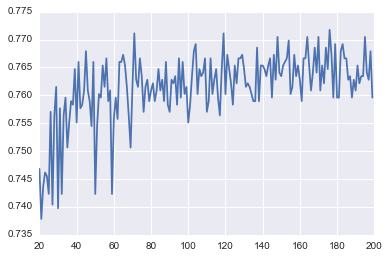

In [128]:
estimator_max, max_oob = estimator_test(data, 20, 200)
print("Number of trees with maximum oob:", estimator_max)
print("Maximum oob:", max_oob)

### Best number of maximum depth

We do the same with the maximum depth of the trees.

Depth with maximum oob: 8
Maximum oob: 0.769820971867


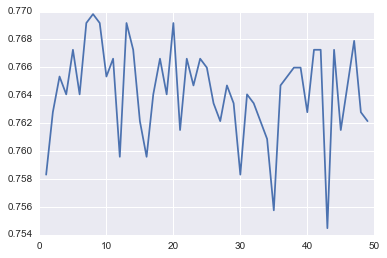

In [129]:
depth_max, max_oob = depth_test(data, 1, 50, estimator_max)
print("Depth with maximum oob:", depth_max)
print("Maximum oob:", max_oob)

### Best number of maximum features

We do the same with the maximum features used by the trees. We check for values 1 to the total number of features 

Number of features with maximum oob: 8
Maximum oob: 0.772378516624


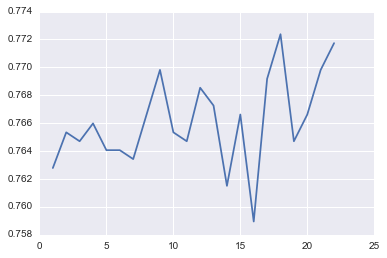

In [130]:
features_max, max_oob = features_test(data, 1, data.shape[1], estimator_max, depth_max)
print("Number of features with maximum oob:", depth_max)
print("Maximum oob:", max_oob)

## Conclusion on parameters selection

We observe on the three graphs that the oob values remains almost the same for every value tested. This is not a very conforting conclusion and tends to show that our classifier performs pretty bad

# Evaluate performance of the classifier

In order to evaluate the classifier, we will first take a look at the oob score first.

In [136]:
forest = RandomForestClassifier(n_estimators = estimator_max, 
                                max_features=features_max, 
                                max_depth=depth_max,
                                n_jobs=-1,
                                oob_score=True)

forest_label = data["skin_color"]
forest_data = data.drop(["skin_color"], axis = 1)
forest.fit(forest_data, forest_label)
forest.oob_score_

0.76726342710997442

In order to a good evaluation of the performance, we will now run a classifier, using train data and the parameters values computed before, and test it with test data

In [137]:
#Split data into train and test data (70% of train data)
train_data, test_data, train_labels, test_labels = split_data(forest_data, forest_label, ratio=0.7)
#Create classifier with optimal parameters
forest = RandomForestClassifier(n_estimators = estimator_max, 
                                max_features=features_max, 
                                max_depth=depth_max,
                                n_jobs=-1,
                                oob_score=True)

forest.fit(train_data, train_labels)
#Compute the prediction and get accuracy
test_pred = forest.predict(test_data)
metrics.accuracy_score(test_labels, test_pred)

0.80000000000000004

The accuracy score sound pretty good, with 80% of well classified data, but before jumping to conclusion, let first take a look at the data.   

We start by looking the proportion of skin-color in the test data

In [138]:
df_test_labels = test_labels.to_frame()
df_test_labels.index = range(0, len(df_test_labels))
df_test_labels.columns=["skin_color_labels"]
df_test_labels.groupby("skin_color_labels").size()/len(test_labels)*100.0

skin_color_labels
0    78.762887
1    21.237113
dtype: float64

We observe that there is 78.7% of white people in the test data, meaning that a classifier that simply classify all input as white players would perform 78.7% accuracy... This lower a bit our excitation about the result, but let's now take a deeper look at the classifier does well or not.

We first print the confusion matrix of our classifier

Confusion matrix, without normalization
[[372  10]
 [ 86  17]]
Normalized confusion matrix
[[ 0.97  0.03]
 [ 0.83  0.17]]


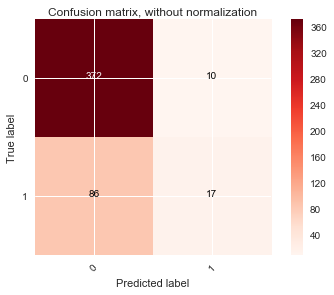

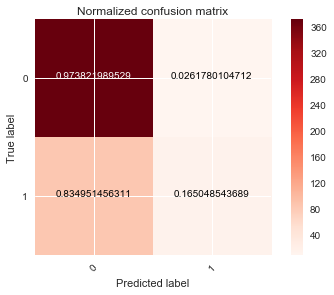

In [139]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(df_test_labels, df_pred)
class_names = ["0","1"]
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

We boserve that white players are very well classified (>97,3%) 
But the black players are very badly classified (>83% classified as white players)

This corresponds to our first impression that classifiers perform very badly, and almost simply classify every players as white.

## Features importance

Now that we found the best parameters for our Random Forest Classifier, we want to know what are the most important features used by it.

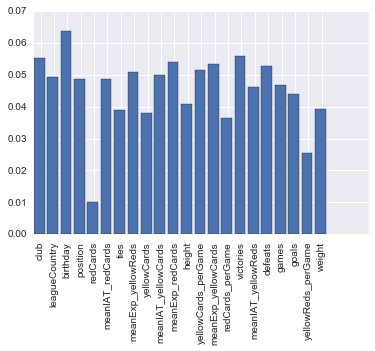

In [140]:
forest, train_dat, train_labels, test_data, test_labels = run_forest_importance(data)

### Removing features

We will now try to remove features that we suspect are not important to classify players by colors in order to see if we can obtain better results.   

We therefore remove the following features:
* birthday: Because we expect to have similar distributions of white and black players in term of ages
* victories, defeats, ties: Because we don't think that players color have an impact on the result of a game. 
* yellowCards, yellowReds, redCards: Because as explained in DataCleaning section, we believe that cards/games ratio makes more sense to classify players
* games: Because we expect to have similar distributions of white and black players in term of games played
* goals: Because we don't expect to see difference in terms of goals according to players race

In [145]:
removed_features = ["birthday","victories","ties","defeats","yellowCards","yellowReds","redCards","games","goals"]
new_data = data.drop(removed_features, axis=1)

ValueError: labels ['yellowReds'] not contained in axis

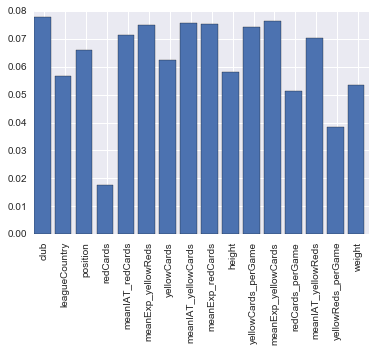

In [142]:
forest, train_dat, train_labels, test_data, test_labels = run_forest_importance(new_data)

In [143]:
test_pred = forest.predict(test_data)
metrics.accuracy_score(test_labels, test_pred)

0.78762886597938142